# Predicción de valores en series de criptomonedas

### 1) Instalamos e importamos librerias

In [2]:
!pip install pickle5

     |████████████████████████████████| 256 kB 14.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import timeit
from tqdm import tqdm
import pickle5 as pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [4]:
!sudo pip install git+https://github.com/gon-uri/cripto_forecast --quiet
from cripto_forecast.utils import series_train_test_split, TimeseriesDataset
from cripto_forecast.utils import MyConv1dPadSame, MyMaxPool1dPadSame,BasicBlock,ResNet1D

In [5]:
import urllib.request

# Load Network parameters from github
url = "https://github.com/gon-uri/cripto_forecast/blob/main/models/1DConv_close_btc_ADP_dictionary.pickle?raw=true"
parameters_dictionary, headers = urllib.request.urlretrieve(url, filename="parameters_dictionary")
file_parameters_dictionary = open(parameters_dictionary, 'rb')
parameters_dictionary = pickle.load(file_parameters_dictionary)

# Load Network parameters from github
url = "https://github.com/gon-uri/cripto_forecast/blob/main/models/1DConv_close_btc_ADP.pt?raw=true"
model_parameters, headers = urllib.request.urlretrieve(url, filename="model_parameters.pt")


In [6]:
# Dfinimos función para uso de CUDA
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
  
# Set the device (check if gpu is available)
device = set_device()

### 2) Carga de Parametros

Definimos los hiperparámetros del Dataset y de la Red Neuronal

In [18]:
# Dataset Parameters
BATCH_SIZE = parameters_dictionary['BATCH_SIZE']
SEQ_LEN = parameters_dictionary['SEQ_LEN']
TEST_RATIO = parameters_dictionary['TEST_RATIO']
COIN = parameters_dictionary['COIN']
PORCENTAJE = parameters_dictionary['PORCENTAJE']
PASOS_FUTURO = parameters_dictionary['PASOS_FUTURO']
REGRESSION = parameters_dictionary['REGRESSION']
NOISE_LEVEL = parameters_dictionary['NOISE_LEVEL']
REDUCTION_STEP = parameters_dictionary['REDUCTION_STEP']
list_coins = ['close_ada', 'close_avax', 'close_btc', 'close_cake', 'close_dot','close_eth', 'close_link', 'close_matic', 'close_sol', 'close_theta','close_vet']
coin_dic = dict(zip(list_coins, range(len(list_coins))))

# Network Parameters
base_filters = parameters_dictionary['base_filters']
kernel_size = parameters_dictionary['kernel_size']
n_block = parameters_dictionary['n_block']
n_classes = parameters_dictionary['n_classes']
stride = parameters_dictionary['stride']
groups = parameters_dictionary['groups']
lr = parameters_dictionary['lr']

### 3) Carga del Dataset

Se carga el dataset desde github ya preprocesado. Este archivo de los datos ya procesados se genera cuando se ejecuta el script de entrenamiento. Se podría volver a procesar los datos desde el dataset RAW, pero este dataset es mucho mas pesado que el dataset ya preprocesado.

In [20]:
import requests
from os import getcwd

# Descargamos el archivo desde github
url = 'https://github.com/gon-uri/cripto_forecast/blob/main/data/data_X_btc_ADP.npy?raw=true'
!wget --no-cache --backups=1 {url}

# Leemos en tensor de numpy
X = np.load('data_X_btc_ADP.npy?raw=true',allow_pickle=False)

# Descargamos el archivo desde github
url = 'https://github.com/gon-uri/cripto_forecast/blob/main/data/data_Y_btc_ADP.npy?raw=true'
!wget --no-cache --backups=1 {url}

# Leemos en tensor de numpy
serie_target = np.load('data_Y_btc_ADP.npy?raw=true',allow_pickle=False)

# Descargamos el archivo desde github
url = 'https://github.com/gon-uri/cripto_forecast/blob/main/data/faulty_indices_btc_ADP.npy?raw=true'
!wget --no-cache --backups=1 {url}

# Leemos en tensor de numpy
faulty_indices = np.load('faulty_indices_btc_ADP.npy?raw=true',allow_pickle=False)

--2021-12-18 08:07:41--  https://github.com/gon-uri/cripto_forecast/blob/main/data/data_X_btc_ADP.npy?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gon-uri/cripto_forecast/raw/main/data/data_X_btc_ADP.npy [following]
--2021-12-18 08:07:41--  https://github.com/gon-uri/cripto_forecast/raw/main/data/data_X_btc_ADP.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gon-uri/cripto_forecast/main/data/data_X_btc_ADP.npy [following]
--2021-12-18 08:07:42--  https://raw.githubusercontent.com/gon-uri/cripto_forecast/main/data/data_X_btc_ADP.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.

### 4) Carga y uso del modelo

Definimos una red neuronal utilizando las funciones de `utils.py`.

In [21]:
# Number of Features
features_dim = X.shape[1]

model = ResNet1D(
    in_channels=features_dim, 
    base_filters=base_filters, 
    kernel_size=kernel_size, 
    stride=stride, 
    n_block=n_block, 
    groups=groups,
    n_classes=n_classes, 
    downsample_gap=max(n_block//8, 1), 
    increasefilter_gap=max(n_block//4, 1), 
    verbose=False).to(device)

# How many trainable parameters does our model have?
num_model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in num_model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  4918401



Cargamos los parametros aprendidos durante en entrenamiento.

In [22]:
if device == 'cpu':
    model.load_state_dict(torch.load(model_parameters,map_location=torch.device('cpu')))
else: 
    model.load_state_dict(torch.load(model_parameters))

### 5) Predicción del mercado a futuro (1 hora)

In [11]:
# Modelo en modo de evaluación
model = model.float()
model.eval()

# Tomamos la última secuencia del dataset para predecir
instance = X[-SEQ_LEN:]
instance = instance[len(instance)%REDUCTION_STEP:]
instance = np.add.reduceat(instance, np.arange(0, len(instance), REDUCTION_STEP),axis = 0)
instance = np.transpose(instance, (1, 0))
instance = np.expand_dims(instance,axis=0)
instance = torch.from_numpy(instance).float()

# Compute model output
output = model(instance)
value_predicted = output.item()/100

In [13]:
print(f'Log return predicted by the Model in {PASOS_FUTURO} minutes: {value_predicted}')
if value_predicted > 0:
    print(f'Market UP')
else:
    print(f'Market DOWN')

Log return predicted by the Model in 60 minutes: 0.002736578583717346
Market UP


### 6) Evaluamos el modelo sobre todos los datos de test (último 20% de los datos de entrenamiento)

In [23]:
# Definimos el target
Y = serie_target[:,coin_dic[COIN]:coin_dic[COIN]+1]

# Separamos en Train y Test
X_train, Y_train, X_test, Y_test, faulty_indices_train, faulty_indices_test = series_train_test_split(X,Y,faulty_indices,test_ratio = TEST_RATIO)

# Definimos el dataloader (carga los datos del Test set)
std_series = np.std(X_train,axis=0)
std_series_test = np.zeros_like(std_series)
valid_dataset = TimeseriesDataset(X_test, Y_test, faulty_indices_test, std_series_test , PASOS_FUTURO, NOISE_LEVEL ,REDUCTION_STEP ,seq_len=SEQ_LEN, is_train = 0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last=True)

Vamos a calcular todas las predicciones para los datos de test y compararlas con los valores reales.

In [24]:
# Evaluate on the validation set for this epoch
real_list = np.asarray([])
pred_list = np.asarray([])
model.eval()
for inputs, labels in valid_loader:

    # Move batch inputs and labels to gpu
    inputs = inputs.float()
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output = model(inputs)

    # output = torch.sigmoid(output)
    # pred_list.append(output.squeeze().detach().cpu().numpy())
    # real_list.append(labels.squeeze().detach().cpu().numpy())

    pred_list = np.concatenate([pred_list,output.squeeze().detach().cpu().numpy()],axis=0)
    real_list = np.concatenate([real_list,labels.squeeze().detach().cpu().numpy()],axis=0)

y_score = np.asarray(pred_list)
y_test = np.asarray(real_list)

# Importamos libreria con métricas
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test>0, y_score)
roc_auc = auc(fpr, tpr)

# Compute Test Set accuracy
acc = accuracy_score(y_test>0, y_score>0)

Por último graficamos el desempeño en el test en términos de la curva ROC.

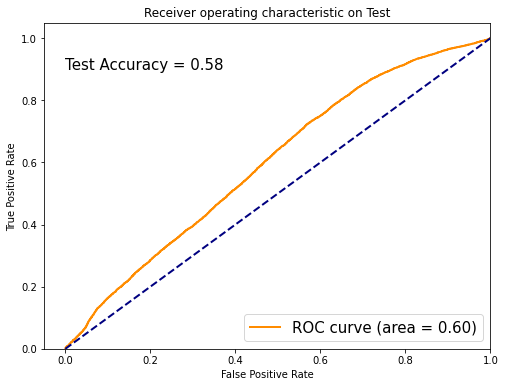

In [27]:
fig = plt.figure(figsize = (8, 6))
lw = 2

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.text(0, 0.9, r'Test Accuracy = %0.2f'% acc,fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic on Test")
plt.legend(loc="lower right",fontsize=15)
plt.show()